##  **Exploratory Data Analysis**

Missing values and outliers in the columns selected for the study need to be reviewed. Missing values should be removed or imputed, while outliers should be removed, transformed, or otherwise treated during the analysis.

### Import libraries and parameters
First, we are going to import the libraries needed to perform data ingestion.

In [274]:
# Import libraries
import os
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon

import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
from dateutil import parser
import zipfile
from collections import Counter

from modules.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, URL_LIST, POLLUTANTS, MUNICIPALITY

WATER_QUALITY_FILE = "water_quality_data.xlsb"
SUBDIR = "../data/raw/"
ALL_POLLUTANTS = [
 'ALC_FEN',
 'ALC_TOT',
 'CO3',
 'HCO3',
 'OH',
 'CLOROF_A',
 'COLI_FEC',
 'COLI_TOT',
 'E_COLI',
 'COT',
 'COT_SOL',
 'DBO_SOL',
 'DBO_TOT',
 'DQO_SOL',
 'DQO_TOT',
 'N_NH3',
 'N_NO2',
 'N_NO3',
 'N_ORG',
 'N_TOT',
 'N_TOTK',
 'TOX_D_48_UT',
 'TOX_D_48_SUP_UT',
 'TOX_D_48_FON_UT',
 'TOX_FIS_SUP_15_UT',
 'TOX_FIS_SUP_30_UT',
 'TOX_FIS_SUP_5_UT',
 'TOX_FIS_FON_15_UT',
 'TOX_FIS_FON_30_UT',
 'TOX_FIS_FON_5_UT',
 'TOX_V_15_UT',
 'TOX_V_30_UT',
 'TOX_V_5_UT',
 'AOXF',
 'AOXP',
 'AOXT',
 'P_TOT',
 'PO4_TOT',
 'ORTO_PO4',
 'COLOR_VER',
 'TRANSPARENCIA',
 'ABS_UV',
 'SDT',
 'CONDUC_CAMPO',
 'CONDUC_CAMPO_SUP',
 'CONDUC_CAMPO_MED',
 'CONDUC_CAMPO_FON',
 'pH_CAMPO',
 'pH_CAMPO_SUP',
 'pH_CAMPO_MED',
 'pH_CAMPO_FON',
 'SALINIDAD_SUP',
 'SALINIDAD_MED',
 'SALINIDAD_FON',
 'OD_%',
 'OD_mg/L',
 'OD_%_SUP',
 'OD_mg/L_SUP',
 'OD_%_MED',
 'OD_mg/L_MED',
 'OD_%_FON',
 'OD_mg/L_FON',
 '1,1,1,2_TTCETA',
 '1,1,2,2_TETRACLETAN',
 '1,1,2_TCETA',
 '1,1_DICLETILEN',
 '1,2,4_TRICLBENCEN',
 '1,2_DIBR_3_CLPROPAN',
 '1,2_DICLETAN',
 '1,2_DICLPROPAN',
 '1,2_DIFENILHIDRACINA',
 '1_C_NAF',
 '2,3_DICLOROFENOL_DCF',
 '2,4,5_T',
 '2,4,5_TRICLOROFENOL',
 '2,4,6_TRICLFENOL',
 '2,4_D_D_C_FENOXIACETICO',
 '2,4_DICLFENOL',
 '2,4_DIMETILFEN',
 '2,4_DINITOL',
 '2,4_DNF',
 '2,6_DINTOL',
 '2_CEVE',
 '2_CF',
 '2_CLNAFT',
 '2_NIFENOL',
 '4_BRFENFENETER',
 '4_NITROFENOL',
 'ACENAF',
 'ACENAFTIL',
 'ANTRA',
 'BEN_A_ANT',
 'BEN_A_PIR',
 'BEN_B_FANT',
 'BEN_G,H,I_PER',
 'BEN_K_FANT',
 'CRISENO',
 'DIBEN_ANT',
 'FENANTRENO',
 'FLUORANTENO',
 'FLUORENO',
 'IND_PIR',
 'NAFTALENO',
 'PIRENO',
 'HAPS',
 'ACRILONITRILO',
 'ACROLEINA',
 'AL_TOT',
 'ALACLOR',
 'ALDICARB',
 'ALDRIN',
 'ATRAZINA',
 'B_TOT',
 'B2_ETILHEXIL_FTALATO',
 'BA_TOT',
 'BE_TOT',
 'BENCENO',
 'BENCIDINA',
 'BIS2_CLETETER',
 'BIS2_CLIOISOPET',
 'BOLSTAR',
 'BPCS',
 'BR_CLMET',
 'BROMOMETANO',
 'CARBOFURANO',
 'CIS_1,2_DICLETEN',
 'CL_BENC',
 'CL_METILENO',
 'CL_RES',
 'CLORATALONIL',
 'CLORDANO',
 'CLOROMETANO',
 'CLOROTOLURON',
 'CLORPIRYFOS',
 'CLORURO_DE_VINILO',
 'CLORUROS_TOT',
 'COUMAFOS',
 'CR_HEX',
 'CYANACINA',
 'DALAPON',
 'DDD',
 'DDE',
 'DDT',
 'DELTAMETRINA',
 'DEMETON_S',
 'DI_2_ETILEXIL_ADIPATO',
 'DIAZINON',
 'DICAMBA',
 'DICLORVOS',
 'DIELDRIN',
 'DIET_FTAL',
 'DIMETIL_FTAL',
 'DIMETOATO',
 'DINITRO_O_CRESOL',
 'DINOSEB',
 'DIURON',
 'END_ALD',
 'ENDO_SUL',
 'ALFA_ENDO',
 'BETA_ENDO',
 'ENDO_SULSO4',
 'ENDRIN',
 'ENTEROC_FEC',
 'EPN',
 'ESTIRENO',
 'ETILBENCENO',
 'ETOPROP',
 'FE_TOT',
 'FENITROTION',
 'FENOL',
 'FENOLES_TOT',
 'FENSULFOTION',
 'FENTION',
 'FLUORUROS_TOT',
 'FORATO',
 'GLIFOSATO',
 'GRAS_ACEI',
 'H_HELMINTOS',
 'HEPTA_EPOX',
 'HEPTACLOR',
 'HEXACL_BENC',
 'HEXACL_BUT',
 'HEXACL_CICLOPEN',
 'HEXACL_ETANO',
 'ISO_FOR',
 'ISOPROTURON',
 'K_TOT',
 'LINURON',
 'MALATION',
 'MAT_FLOTANTE',
 'MCPA',
 'MERFOS',
 'METIL_AZINF_GUT',
 'METILPARATION',
 'METILTERBUTILETER_MTBE_',
 'METOLACLOR',
 'METOXICLO',
 'MEVINFOS',
 'MIREX',
 'MN_TOT',
 'MO_TOT',
 'MOLINATO',
 'N_NITROS_DIMETILA',
 'N_NITROS_N_PROPAM',
 'N_NITROSODIFENILAMINA',
 'NA_TOT',
 'NITROBENCENO',
 'OXAMIL',
 'PARATION',
 'PCBEN',
 'PENDIMETALIN',
 'PENTACLOROFENOL',
 'PICLORAN',
 'PIRYPROXYFEN',
 'RONNEL',
 'SAAM',
 'SB_TOT',
 'SE_TOT',
 'SILVEX',
 'SIMAZINA',
 'SIO2',
 'SO4_TOT',
 'SOLID_SED',
 'SST',
 'SULFOTEP',
 'SULFUROS_TOT',
 'TALIO',
 'TERBUFOS',
 'TERBUTILAZINA',
 'TETRACL_CARB',
 'TETRACLOROETILENO_',
 'TOKUTION',
 'TOLUENO',
 'TOXAFENO',
 'TRANS_1,2_DICLOROETILENO',
 'TRIALATO',
 'TRICLORANATO',
 'TRICLORFON',
 'TRICLOROETILENO',
 'TRICLOROFLUOROMETANO',
 'TRIFLURALIN',
 'TURBIEDAD',
 'AS_TOT',
 'CD_TOT',
 'CR_TOT',
 'HG_TOT',
 'NI_TOT',
 'PB_TOT',
 'CN_TOT',
 'CU_TOT',
 'ZN_TOT',
 'POT_REDOX_CAMPO',
 'POT_REDOX_CAMPO_FON',
 'POT_REDOX_CAMPO_MED',
 'POT_REDOX_CAMPO_SUP',
 'ACENAF_8310',
 'ACENAFTIL_8310',
 'ANTRA_8310',
 'BEN_A_ANT_8310',
 'BEN_A_PIR_8310',
 'BEN_B_FANT_8310',
 'BEN_G,H,I_PER_8310',
 'BEN_K_FANT_8310',
 'CRISENO_8310',
 'DIBEN_ANT_8310',
 'FENANTRENO_8310',
 'FLUORANTENO_8310',
 'FLUORENO_8310',
 'IND_PIR_8310',
 'NAFTALENO_8310',
 'PIRENO_8310',
 'HAPS_8310',
 '1,2_DICLBENC',
 '1,3_DICLBEN',
 '1,4_DICLBEN',
 'DICLOROBENCENOS',
 'BR_DICLMET',
 'BROMOF',
 'CLOROFORMO',
 'DIBR_CLMET',
 'THMs',
 'M,P_XILENO',
 'O_XILENO',
 'XILEN_ISOMEROS',
 'ALFA_BHC',
 'BETA_BHC',
 'GAMA_BHC_LIN',
 'DELTA_BHC',
 'BHC_ISOMEROS',
 'CA_TOT',
 'MG_TOT',
 'DUR_TOT',
 'TEMP_AMB',
 'TEMP_AGUA',
 'TEMP_AGUA_SUP',
 'TEMP_AGUA_MED',
 'TEMP_AGUA_FON',
 'PROFUNDIDAD',
 'CAUDAL',
 'CLORUROS_SOL',
 'FLUORUROS_SOL',
 'SO4_SOL',
 'AS_SOL',
 'CD_SOL',
 'CR_SOL',
 'FE_SOL',
 'MN_SOL',
 'HG_SOL',
 'PB_SOL',
 'ZN_SOL',
 'AL_SOL',
 'CU_SOL',
 'TALIO_SOL',
 'NI_SOL',
 'CA_SOL',
 'MG_SOL',
 'K_SOL',
 'NA_SOL',
 'SULFUROS_SOL',
 'BA_SOL',
 'SB_SOL',
 'AG_TOT',
 'S',
 'AMPA',
 'V_TOT',
 'SE',
 'SSV',
 'C.MESÓFILOS AEROBIOS',
 'DUR_Ca',
 'DUR_Mg',
 'NH4',
 'ST',
 'DIBR_MET',
 'DIBROMOETILENO',
 'S_TOT',
 '1,1-DICLOROPROPILENO',
 '1,2,3_TRICLBENCEN',
 '1,2-DIBR_ETA',
 '1,3,5-TRIMETILBENCENO',
 '1,3_DICLPROPAN',
 '2_CLOROTOLUENO',
 '2_METILFEN',
 '4_CLOROTOLUENO',
 '4-ISOPROPILTOLUENO',
 'ALC_A',
 'AZOBENCENO',
 'BIS_2_CLOROETOXI_MET',
 'BISMUTO',
 'BROMATOS',
 'BROMOBENCENO',
 'BUTILBENCILFTALATO',
 'CARBAZOLA',
 'CIS-CLORDANO',
 'CLORAMINAS_COMO_CL2_',
 'CLORITOS',
 'CLOROF_B',
 'CLOROF_C',
 'CO_TOT',
 'COLOR_APA',
 'COLOR_VER_436',
 'COLOR_VER_525',
 'COLOR_VER_620',
 'COMP_ORG_NO_HALOG_FID_CONH',
 'CONDUC_LAB',
 'COP',
 'DIBENZOFURANO',
 'DIBUTILFTALATO (DBP)',
 'DICLOROMETANO',
 'DI-OCTILFTALATO',
 'DIQUAT',
 'ENDOSULFAN II',
 'ENDOTAL',
 'ENDRÍN CETONA',
 'HIDROCAR_F_MED',
 'HIDROCAR_F_PES',
 'ISOPROPILBENCENO',
 'Li_TOT',
 'N_NO3-N_NO2',
 'N_ORG_SOL',
 'N-BUTILBENCENO',
 'N-PROPILBENCENO',
 'O-NITROANILINA',
 'P_INORG',
 'P_INORG_DIS',
 'P_ORG',
 'P-CLOROANILINA',
 'pH_LAB',
 'SALINIDAD ',
 'SDF',
 'SDV',
 'SEC-BUTILBENCENO',
 'SN_TOT',
 'SR_TOT',
 'SSF',
 'STF',
 'STV',
 'TALIO_TOT',
 'TER-BUTILBENCENO',
 'Ti_TOT',
 'TRANS-CLORDANO',
 'FORMALDEHIDO',
 'CLORATOS',
 'ACID_CLOROACE',
 'ACID_DICLOROACE',
 'ACID_TRICLOROACE'
 ]

### Load data
We upload the data from the sites and the results of the measurements of the different pollutants. Merge df_water_site and df_water_result DataFrames using 'CLAVE SITIO' as the key. The 'inner' join returns only rows with matching values in both DataFrames. We select the columns required for the study, and in this case we need to select all the pollulants.

In [238]:
df_water_site = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=0)
df_water_result = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=1, parse_dates=['FECHA REALIZACIÓN'])

/tmp/ipykernel_208758/801284402.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_water_result = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=1, parse_dates=['FECHA REALIZACIÓN'])


In [242]:
# Merging df_water_site and df_water_result DataFrames using 'CLAVE SITIO' as the key.
df_water_merged = pd.merge(
    df_water_site, 
    df_water_result, 
    on='CLAVE SITIO', 
    how='inner'
)

# Select the columns required for the study
df_water_merged_filtered = df_water_merged[
    ['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'] + 
    ALL_POLLUTANTS
]

# Convert the 'FECHA REALIZACIÓN' column to the correct datetime format
# First convert the column to numeric
df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_numeric(df_water_merged_filtered['FECHA REALIZACIÓN'], errors='coerce')

# Then convert to dates from Excel origin
df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_datetime(
    df_water_merged_filtered['FECHA REALIZACIÓN'], 
    origin='1899-12-30', 
    unit='D'
)

# Filter the DataFrame to obtain only the records of the water bodies that are not "COASTAL" of the affected municipalities of the state of Sonora.
df_water_filtered_sonora = df_water_merged_filtered[
    (df_water_merged['ESTADO'] == 'SONORA') &
    (df_water_merged['MUNICIPIO'].isin(MUNICIPALITY))   
]
df_water_filtered_sonora = df_water_filtered_sonora[
    ~df_water_filtered_sonora['TIPO CUERPO DE AGUA'].str.contains('COSTERO', na=False)
]

# Clean the columns of pollutants by removing the '>' and '<' symbols and converting them to numeric
for column in ALL_POLLUTANTS:
    if column in df_water_filtered_sonora.columns:
        df_water_filtered_sonora[column] = df_water_filtered_sonora[column].astype(str)
        df_water_filtered_sonora[column] = (
            df_water_filtered_sonora[column]
            .str.replace('<', '', regex=False)
            .str.replace('>', '', regex=False)
        )
        df_water_filtered_sonora[column] = pd.to_numeric(df_water_filtered_sonora[column], errors='coerce')

# Sort by 'CLAVE SITIO' and 'FECHA REALIZACIÓN' in ascending order
df_water_filtered_sonora.sort_values(
    by=['CLAVE SITIO', 'FECHA REALIZACIÓN'], 
    ascending=True, 
    inplace=True, 
    ignore_index=True
)

/tmp/ipykernel_208758/4223021848.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_numeric(df_water_merged_filtered['FECHA REALIZACIÓN'], errors='coerce')
/tmp/ipykernel_208758/4223021848.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_datetime(


### Missing values treatment
To analyze the missing values ​​of the columns that interest us, we detect the percentage of missing values in every column of the dataset; if a columns contains a lot of missing values, say more than 70%, and the feature is not significant, we might want to ***delete*** that feature. Then, we must to understand the reasons for the randomness, that is, identify whether these values ​​are:
1. **Missing Completely at Random (MCAR):** The missing values on a given variable (Y) are not associated with other variables in a given data set or with the variable (Y) itself. In other words, there is no particular reason for the missing values.
2. **Missing at Random (MAR):** MAR occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information.
3. **Missing Not at Random (MNAR):** Missingness depends on unobserved data or the value of the missing data itself.

From the understanding of the randomness of the data we choose the *imputation method*. Note that our data are *time series*, so the imputation methods selected must correspond to *time series problems*:
* Forward Fill
* BackFill
* KNN Based
* MICE

#### *Deletion*
If a column contains more than 70%, and the feature is not significant, we delete the complete column

In [156]:
df_water_filtered_sonora

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD,FECHA REALIZACIÓN,ALC_FEN,...,STV,TALIO_TOT,TER-BUTILBENCENO,Ti_TOT,TRANS-CLORDANO,FORMALDEHIDO,CLORATOS,ACID_CLOROACE,ACID_DICLOROACE,ACID_TRICLOROACE
0,MET-001,SONORA,ARIZPE,ACUÍFERO BACANUCHI,SUBTERRÁNEO,POZO,30.603729,-110.226908,2021-09-07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MET-001,SONORA,ARIZPE,ACUÍFERO BACANUCHI,SUBTERRÁNEO,POZO,30.603729,-110.226908,2022-07-25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MET-001,SONORA,ARIZPE,ACUÍFERO BACANUCHI,SUBTERRÁNEO,POZO,30.603729,-110.226908,2023-12-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MET-003,SONORA,ARIZPE,RIO BACANUCHI,LÓTICO,RÍO,30.575670,-110.220880,2022-07-25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MET-010,SONORA,ARIZPE,ACUÍFERO RÍO SONORA,SUBTERRÁNEO,POZO,30.347310,-110.157320,2021-10-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,OCNOR6275,SONORA,CANANEA,ACUÍFERO SAN PEDRO,SUBTERRÁNEO,POZO,31.085050,-110.111870,2022-08-15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469,OCNOR6506,SONORA,URES,ACUÍFERO RÍO SONORA,SUBTERRÁNEO,POZO,29.424050,-110.382940,2020-10-31,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470,TOMA DOMICILIARIA ACONCHI,SONORA,ACONCHI,ACUÍFERO RIO SONORA,SUBTERRÁNEO,TOMA DOMICILIARIA,29.821510,-110.227020,2022-08-11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
471,TOMA DOMICILIARIA BACANUCHI ESCUELA,SONORA,ARIZPE,ACUÍFERO RIO BACANUCHI,SUBTERRÁNEO,TOMA DOMICILIARIA,30.605670,-110.235830,2022-07-25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
# Calculate the threshold of 70% of the DataFrame length
threshold = len(df_water_filtered_sonora) * 0.7

# Remove columns with more than 70% null data
df_drop_water_sonora = df_water_filtered_sonora.dropna(axis=1, thresh=threshold)

In [244]:
# Select the remaining columns of pollulants after removing the columns with some amount of null data
df_pollulants = df_drop_water_sonora.drop(columns=['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA',
                                                 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 
                                                 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'])
# df_drop_water_sonora.loc[:, selected_cols].columns
df_pollulants

,COLI_FEC,E_COLI,COT,DBO_TOT,DQO_TOT,N_NH3,N_NO2,N_NO3,N_ORG,N_TOT,...,AS_TOT,CD_TOT,CR_TOT,HG_TOT,NI_TOT,PB_TOT,DUR_TOT,TEMP_AMB,TEMP_AGUA,CAUDAL
0,10.0,NaN,1.3280,NaN,NaN,0.053263,0.005,1.706396,0.32898,2.088639,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,507.3396,33.0,22.1,NaN
1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.738000,NaN,NaN,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,514.0000,30.0,22.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0020,0.001000,0.0020,0.000701,0.00200,0.00200,NaN,NaN,NaN,NaN
3,1658.0,1274.0,NaN,2.0,10.0,NaN,NaN,NaN,NaN,NaN,...,0.0015,0.001301,0.0060,0.000201,0.01700,0.00154,NaN,29.0,29.0,337.0
4,10.0,NaN,0.4537,NaN,NaN,0.078194,0.005,1.054546,1.16265,2.295390,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,345.0658,29.0,19.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,31.0,NaN,NaN,NaN,NaN,NaN,NaN,0.784000,NaN,NaN,...,0.0015,0.001301,0.0060,0.000201,NaN,0.00154,92.4000,27.0,24.0,NaN
469,10.0,NaN,0.8487,NaN,NaN,0.032294,0.005,5.602367,0.01774,5.652401,...,0.0015,0.001301,0.0056,0.000201,0.00042,0.00154,190.0259,32.0,27.7,NaN
470,10.0,NaN,NaN,NaN,NaN,NaN,NaN,5.164000,NaN,NaN,...,0.0080,0.001301,0.0012,0.000201,0.00042,0.00154,404.0000,32.0,27.0,NaN
471,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.602000,NaN,NaN,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,522.0000,27.0,25.0,NaN


#### *Imputation*

We're going to try some imputation methods like ***forward fill***, ***backfill***, ***KNN*** and ***MICE***. For some imputation methods like MICE, the presence of some predictive relationship or correlation between data, can help to improve the quality of imputation. We need to verify that the used columns for imputantion have some kind of correlation (Pearson, Spearman, Kendall Tau). Likewise, we need to understand the reasons for the randomness of data.

In [245]:
# Function to plot heatmap
def heatmap_plot(df, title, vmin = -1, vmax = 1, cmap = 'coolwarm'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, vmin = vmin, vmax = vmax, annot=True, cmap = cmap)
    plt.title(title)
    plt.show()

In [246]:
# Function to calculate correlation of non-null data
def nonnull_correlation(df, lst, max_missing_ratio = 1, method = 'pearson', plthm = True):

    corr = pd.DataFrame()

    # Calculate the percentage of missing data per column
    missing_ratio = df.isnull().mean()

    # Filter columns with a missing data ratio less than the given threshold
    eligible_columns = missing_ratio[missing_ratio <= max_missing_ratio].index

    if len(eligible_columns) == 0:
        # best_corrs[element] = (None, None)
        raise RuntimeError("No eligible columns, try with other max_missing_ratio")
        
    # Calculate correlation only with eligible columns
    correlations = df[eligible_columns].corr(method = method)
    corr = correlations[lst]

    if plthm:
        heatmap_plot(corr, 'Correlation Heatmap (without NaN values)', -1, 1)
    
    return corr

In [247]:
def nullity_correlation(df, lst, method = 'pearson', plthm = True):

    # Select columns that contain at least one null value
    df_null = df.iloc[:, [i for i, n in enumerate(np.var(df.isnull(), axis='rows')) if n > 0]]

    # Calculate correlation
    corr = df_null.isnull().corr(method = method)[lst]

    if plthm:
        heatmap_plot(corr, 'Correlation Heatmap for NaN values', -1, 1)
    
    return corr

In [ ]:
corr_null = nullity_correlation(df=df_pollulants, lst=['COLI_FEC', 'E_COLI'])
corr_null

NameError: name 'nullity_correlation' is not defined

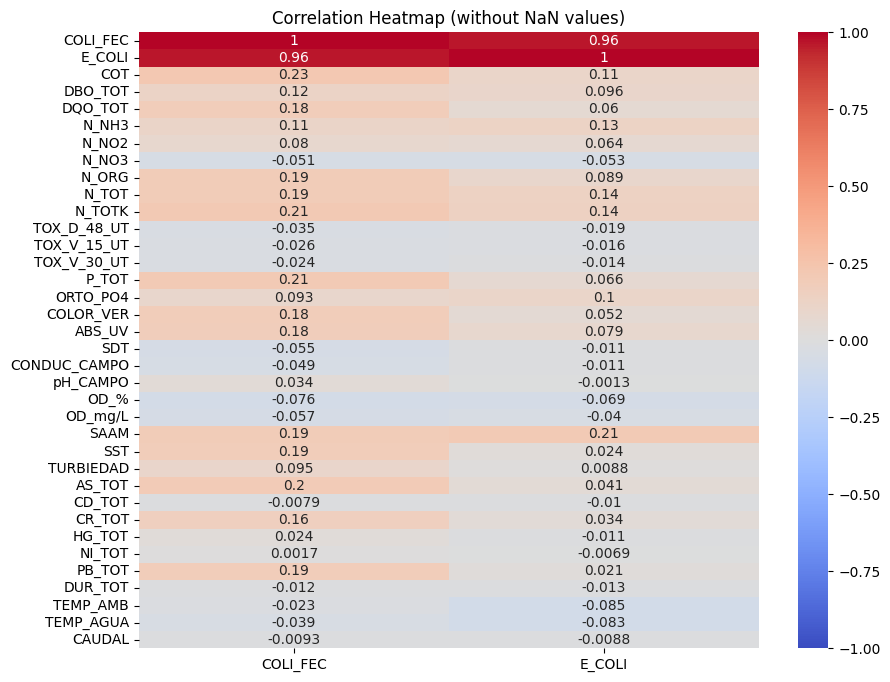

,COLI_FEC,E_COLI
COLI_FEC,1.000000,0.961099
E_COLI,0.961099,1.000000
COT,0.226281,0.108850
DBO_TOT,0.122638,0.096055
DQO_TOT,0.180313,0.060457
N_NH3,0.113617,0.127875
N_NO2,0.079537,0.064413
N_NO3,-0.050969,-0.053470
N_ORG,0.191766,0.089461
N_TOT,0.194215,0.136733


In [249]:
co = nonnull_correlation(df_pollulants, lst=['COLI_FEC', 'E_COLI'])
co


In [250]:
# Function to select the best pairwaise correlation bewteen data correlation and nullity correlation
def best_corr_choice(df1, df2, col):
    mask = co.index != col
    result = abs(df1.loc[mask, col] / df2.loc[mask, col])
    return result.sort_values(ascending=False)


In [251]:
best = best_corr_choice(co, corr_null, 'COLI_FEC')
best

AS_TOT          6.967605
PB_TOT          3.839568
CR_TOT          3.801222
E_COLI          2.657821
HG_TOT          0.652756
DQO_TOT         0.579293
SST             0.573499
SAAM            0.544630
COLOR_VER       0.543821
COT             0.516306
P_TOT           0.431952
N_TOTK          0.409703
ABS_UV          0.404714
DBO_TOT         0.389406
N_TOT           0.381447
N_ORG           0.372454
ORTO_PO4        0.316347
TURBIEDAD       0.313325
OD_%            0.244209
N_NH3           0.218181
OD_mg/L         0.184835
CD_TOT          0.183233
CONDUC_CAMPO    0.156712
N_NO2           0.152735
TOX_D_48_UT     0.117632
TEMP_AGUA       0.079575
pH_CAMPO        0.074939
SDT             0.074315
N_NO3           0.073925
TOX_V_15_UT     0.073097
TOX_V_30_UT     0.066400
CAUDAL          0.029724
TEMP_AMB        0.029471
NI_TOT          0.019850
DUR_TOT         0.017336
Name: COLI_FEC, dtype: float64

In [ ]:
# DataFrame for imputation methods
df_imputation_method = pd.DataFrame()
df= pd.DataFrame()

# Forward Fill
df_imputation_method['COLI_FEC_ffill'] = df_pollulants['COLI_FEC'].fillna(method='ffill', inplace=False)

# BackFill
df_imputation_method['COLI_FEC_bfill'] = df_pollulants['COLI_FEC'].fillna(method='bfill', inplace=False)

# KNN Based
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_imputation_method['COLI_FEC_knn'] = knn_imputer.fit_transform(df_pollulants[['COLI_FEC']])

# MICE
mice_imputer = IterativeImputer(max_iter=100, random_state=0)
imputed_values = mice_imputer.fit_transform(df_pollulants[['COLI_FEC', 'E_COLI']])
df_imputation_method['COLI_FEC_mice'] = imputed_values[:, df_pollulants.columns.get_loc('COLI_FEC')]
# df[['COLI_FEC', 'pH_CAMPO']] = mice_imputer.fit_transform(df_drop_water_sonora[['COLI_FEC', 'pH_CAMPO']])

# MICE
mice_imputer = IterativeImputer(max_iter=100, random_state=0)
imputed_values_II = mice_imputer.fit_transform(df_pollulants)  # This returns a NumPy array

# Create a DataFrame if needed, or directly assign the column
df_imputation_method['COLI_FEC_mice_II'] = imputed_values_II[:, df_pollulants.columns.get_loc('COLI_FEC')]



/tmp/ipykernel_208758/2204273625.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method['COLI_FEC_ffill'] = df_pollulants['COLI_FEC'].fillna(method='ffill', inplace=False)
/tmp/ipykernel_208758/2204273625.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method['COLI_FEC_bfill'] = df_pollulants['COLI_FEC'].fillna(method='bfill', inplace=False)


In [270]:
df_imputation_method

,COLI_FEC_ffill,COLI_FEC_bfill,COLI_FEC_knn,COLI_FEC_mice,COLI_FEC_mice_II
0,10.0,10.0,10.000000,10.000000,10.000000
1,10.0,10.0,10.000000,10.000000,10.000000
2,10.0,1658.0,18321.331858,18321.331858,18321.331858
3,1658.0,1658.0,1658.000000,1658.000000,1658.000000
4,10.0,10.0,10.000000,10.000000,10.000000
...,...,...,...,...,...
468,31.0,31.0,31.000000,31.000000,31.000000
469,10.0,10.0,10.000000,10.000000,10.000000
470,10.0,10.0,10.000000,10.000000,10.000000
471,10.0,10.0,10.000000,10.000000,10.000000


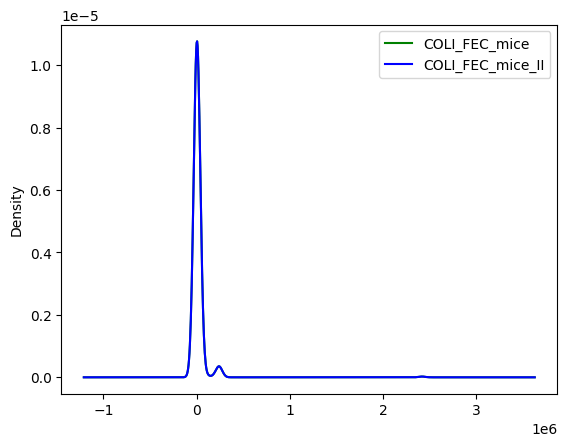

In [273]:
df_imputation_method['COLI_FEC_mice'].plot(kind='kde',color='green')
df_imputation_method['COLI_FEC_mice_II'].plot(kind='kde',color='blue')
# df_drop_water_sonora['N_TOT'].plot(kind='kde',color='red')

plt.legend([
    'COLI_FEC_mice',
    'COLI_FEC_mice_II',
    # 'Original Distribution'
])
plt.show()

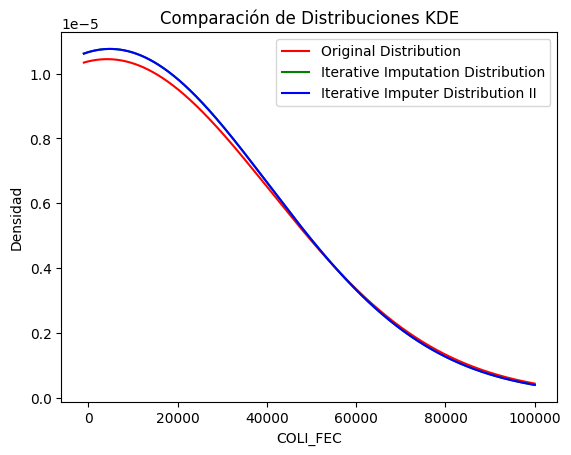

Divergencia de Jensen-Shannon entre 'Iterative Imputer' y 'Original': 0.008109044709710484
Divergencia de Jensen-Shannon entre 'Iterative Imputer II' y 'Original': 0.008109044709710484


In [280]:
# Crear un rango común de x para evaluar las KDEs
x_values = np.linspace(-1000, 100000, 100000)

# Calcular KDEs para cada conjunto de datos
kde_original = gaussian_kde(df_drop_water_sonora['COLI_FEC'].replace([np.inf, -np.inf], np.nan).dropna())(x_values)
kde_iterative = gaussian_kde(df_imputation_method['COLI_FEC_mice'])(x_values)
kde_iterative_II = gaussian_kde(df_imputation_method['COLI_FEC_mice_II'])(x_values)

# Graficar las distribuciones KDE
plt.plot(x_values, kde_original, color='red', label='Original Distribution')
plt.plot(x_values, kde_iterative, color='green', label='Iterative Imputation Distribution')
plt.plot(x_values, kde_iterative_II, color='blue', label='Iterative Imputer Distribution II')
plt.legend()
plt.title("Comparación de Distribuciones KDE")
plt.xlabel("COLI_FEC")
plt.ylabel("Densidad")
plt.show()

# Calcular la Divergencia de Jensen-Shannon entre las distribuciones
js_div_iterative_vs_original = jensenshannon(kde_iterative, kde_original)
js_div_iterative_II_vs_original = jensenshannon(kde_iterative_II, kde_original)

print(f"Divergencia de Jensen-Shannon entre 'Iterative Imputer' y 'Original': {js_div_iterative_vs_original}")
print(f"Divergencia de Jensen-Shannon entre 'Iterative Imputer II' y 'Original': {js_div_iterative_II_vs_original}")


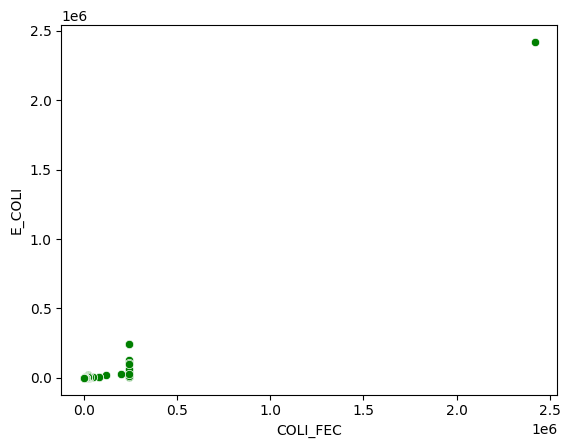

In [226]:
sns.scatterplot(x=df_drop_water_sonora['COLI_FEC'], y=df_drop_water_sonora['E_COLI'], color='green')
plt.show()

In [81]:
df_drop_water_sonora[['COLI_FEC', 'pH_CAMPO']].corr()

,COLI_FEC,pH_CAMPO
COLI_FEC,1.000000,0.033672
pH_CAMPO,0.033672,1.000000


In [ ]:

def plot_heatmap_without_na(df, max_missing_ratio=1.0):
    # Filtrar columnas con un ratio de datos faltantes menor al umbral dado
    missing_ratio = df.isnull().mean()
    eligible_columns = missing_ratio[missing_ratio <= max_missing_ratio].index

    # Filtrar el DataFrame solo con columnas elegibles y eliminar filas con valores nulos
    df_filtered = df[eligible_columns].dropna()

    # Calcular la matriz de correlación
    correlation_matrix = df_filtered.corr()

    # Graficar el heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap (without NaN values)')
    plt.show()

In [241]:
# DataFrame for imputation methods
df_imputation_method = pd.DataFrame()
df= pd.DataFrame()

# Forward Fill
df_imputation_method['COLI_FEC_ffill'] = df_drop_water_sonora['COLI_FEC'].fillna(method='ffill', inplace=False)

# BackFill
df_imputation_method['COLI_FEC_bfill'] = df_drop_water_sonora['COLI_FEC'].fillna(method='bfill', inplace=False)

# KNN Based
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_imputation_method['COLI_FEC_knn'] = knn_imputer.fit_transform(df_drop_water_sonora[['COLI_FEC']])

# MICE
mice_imputer = IterativeImputer(max_iter=20, random_state=0)
df_imputation_method[['COLI_FEC_mice']] = mice_imputer.fit_transform(df_drop_water_sonora[['COLI_FEC', 'pH_CAMPO']][['COLI_FEC']])
# df[['COLI_FEC', 'pH_CAMPO']] = mice_imputer.fit_transform(df_drop_water_sonora[['COLI_FEC', 'pH_CAMPO']])

/tmp/ipykernel_208758/1928616462.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method['COLI_FEC_ffill'] = df_drop_water_sonora['COLI_FEC'].fillna(method='ffill', inplace=False)
/tmp/ipykernel_208758/1928616462.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method['COLI_FEC_bfill'] = df_drop_water_sonora['COLI_FEC'].fillna(method='bfill', inplace=False)


In [30]:
df_imputation_method.head()

,COLI_FEC_ffill,COLI_FEC_bfill,COLI_FEC_knn,COLI_FEC_mice
0,10.0,10.0,10.000000,10.000000
1,10.0,10.0,10.000000,10.000000
2,10.0,1658.0,18321.331858,18321.331858
3,1658.0,1658.0,1658.000000,1658.000000
4,10.0,10.0,10.000000,10.000000


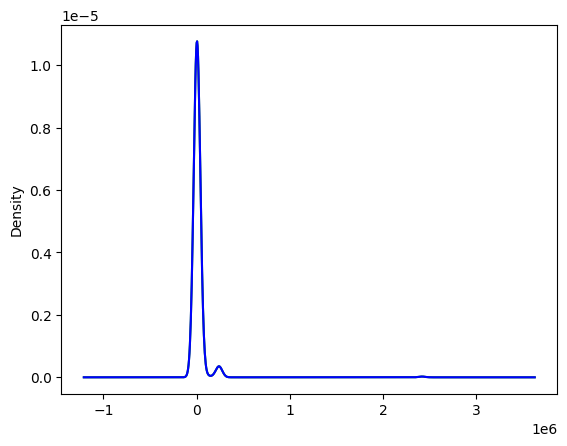

In [35]:
df_imputation_method['COLI_FEC_mice'].plot(kind='kde',color='green')
df['COLI_FEC'].plot(kind='kde',color='blue')


# plt.legend([
#     'Median Imputation Distribution',
#     'Iterative Imputer Distribution',
#     'Original Distribution'
# ])
plt.show()

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('classifier', RandomForestClassifier())
])
print(cross_val_score(pipeline, X, y, scoring="neg_mean_squared_error", cv=3))

/mnt/Data/Documents/Unison/1 Semestre/Ingeniería de Características/Projects/Sonora-River-Farming/Data-Science-Project/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[-6882.92 -8343.56 -7273.72]


In [52]:
for i in POLLUTANTS:
    if i == 'COLI_FEC':
        print(df_drop_water_sonora[i])

0        10.0
1        10.0
2         NaN
3      1658.0
4        10.0
        ...  
468      31.0
469      10.0
470      10.0
471      10.0
472     148.0
Name: COLI_FEC, Length: 473, dtype: float64


Analysing missing values for 'COLI_FEC'

<Axes: >

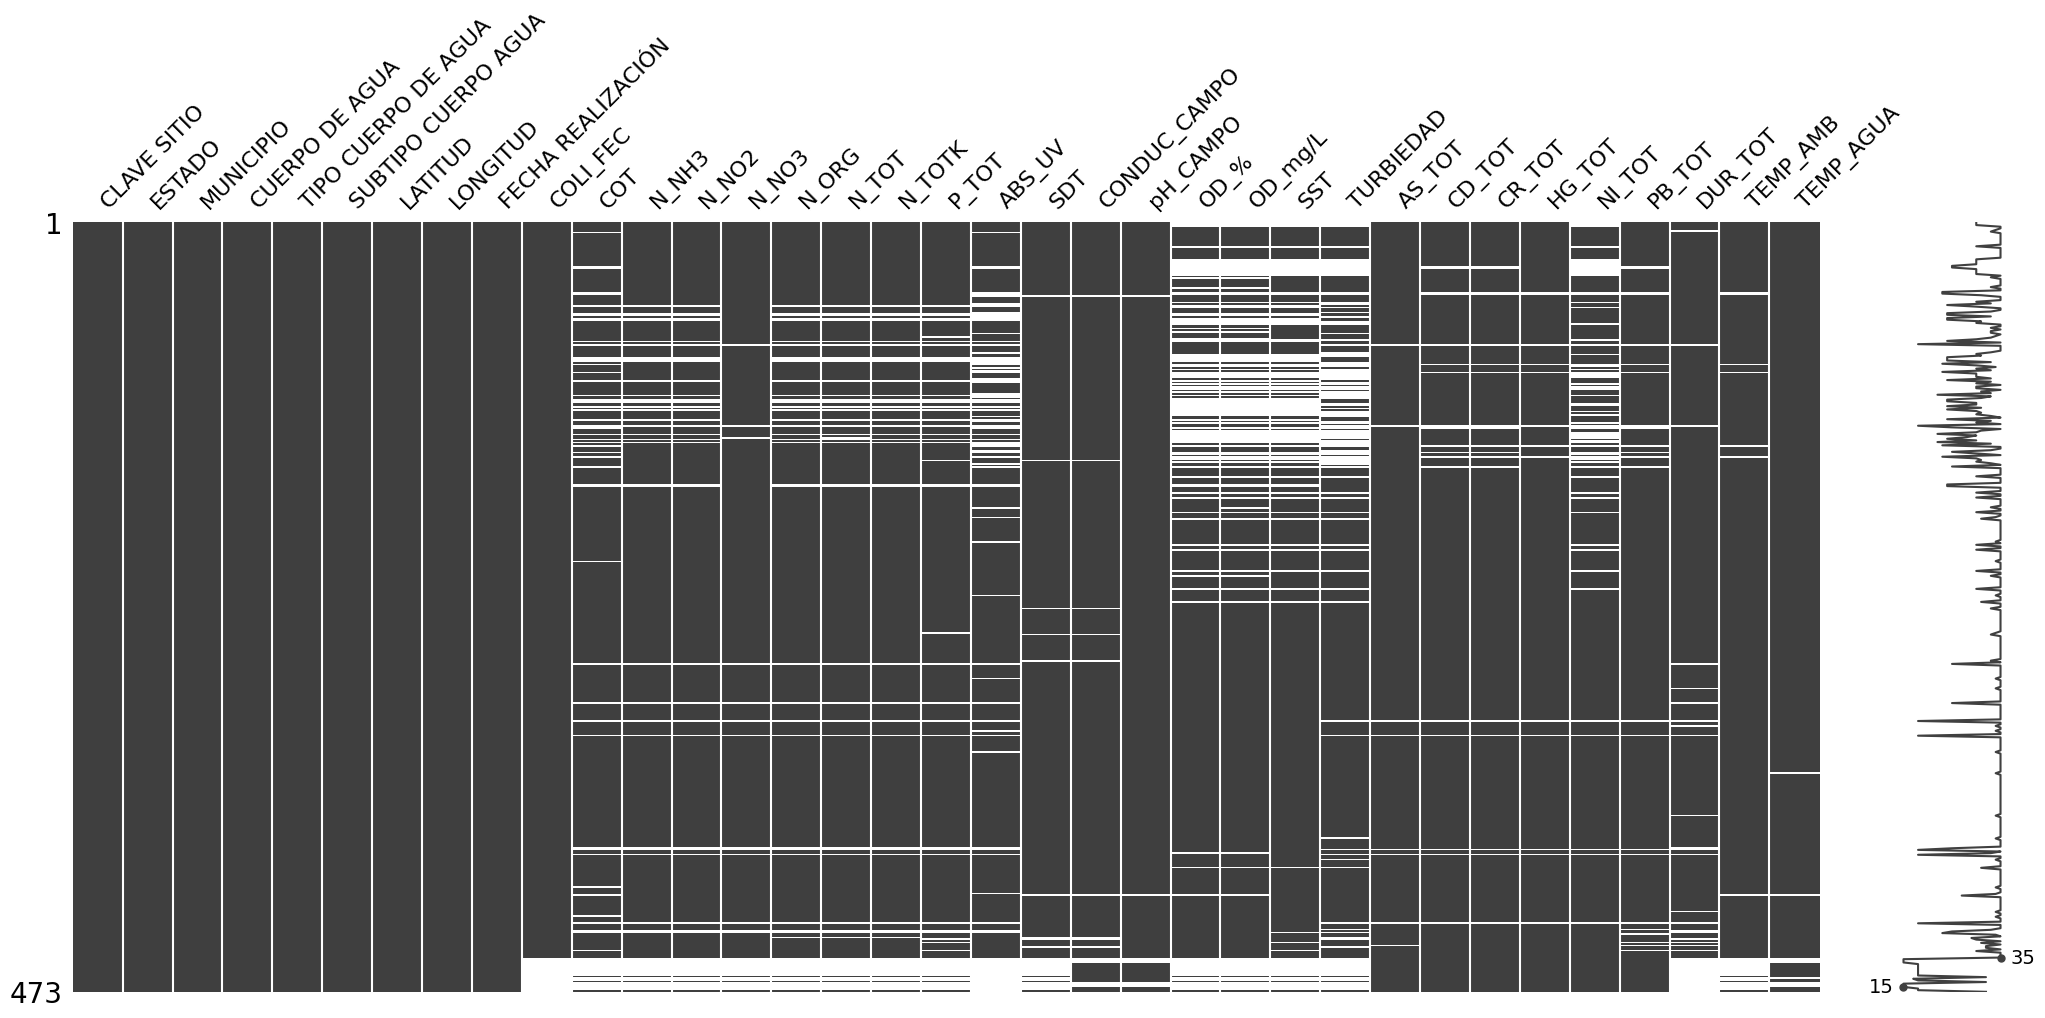

In [47]:
msno.matrix(df_drop_water_sonora.sort_values(by='COLI_FEC', ascending=True))

Analysing missing values for 'N_TOT'

<Axes: >

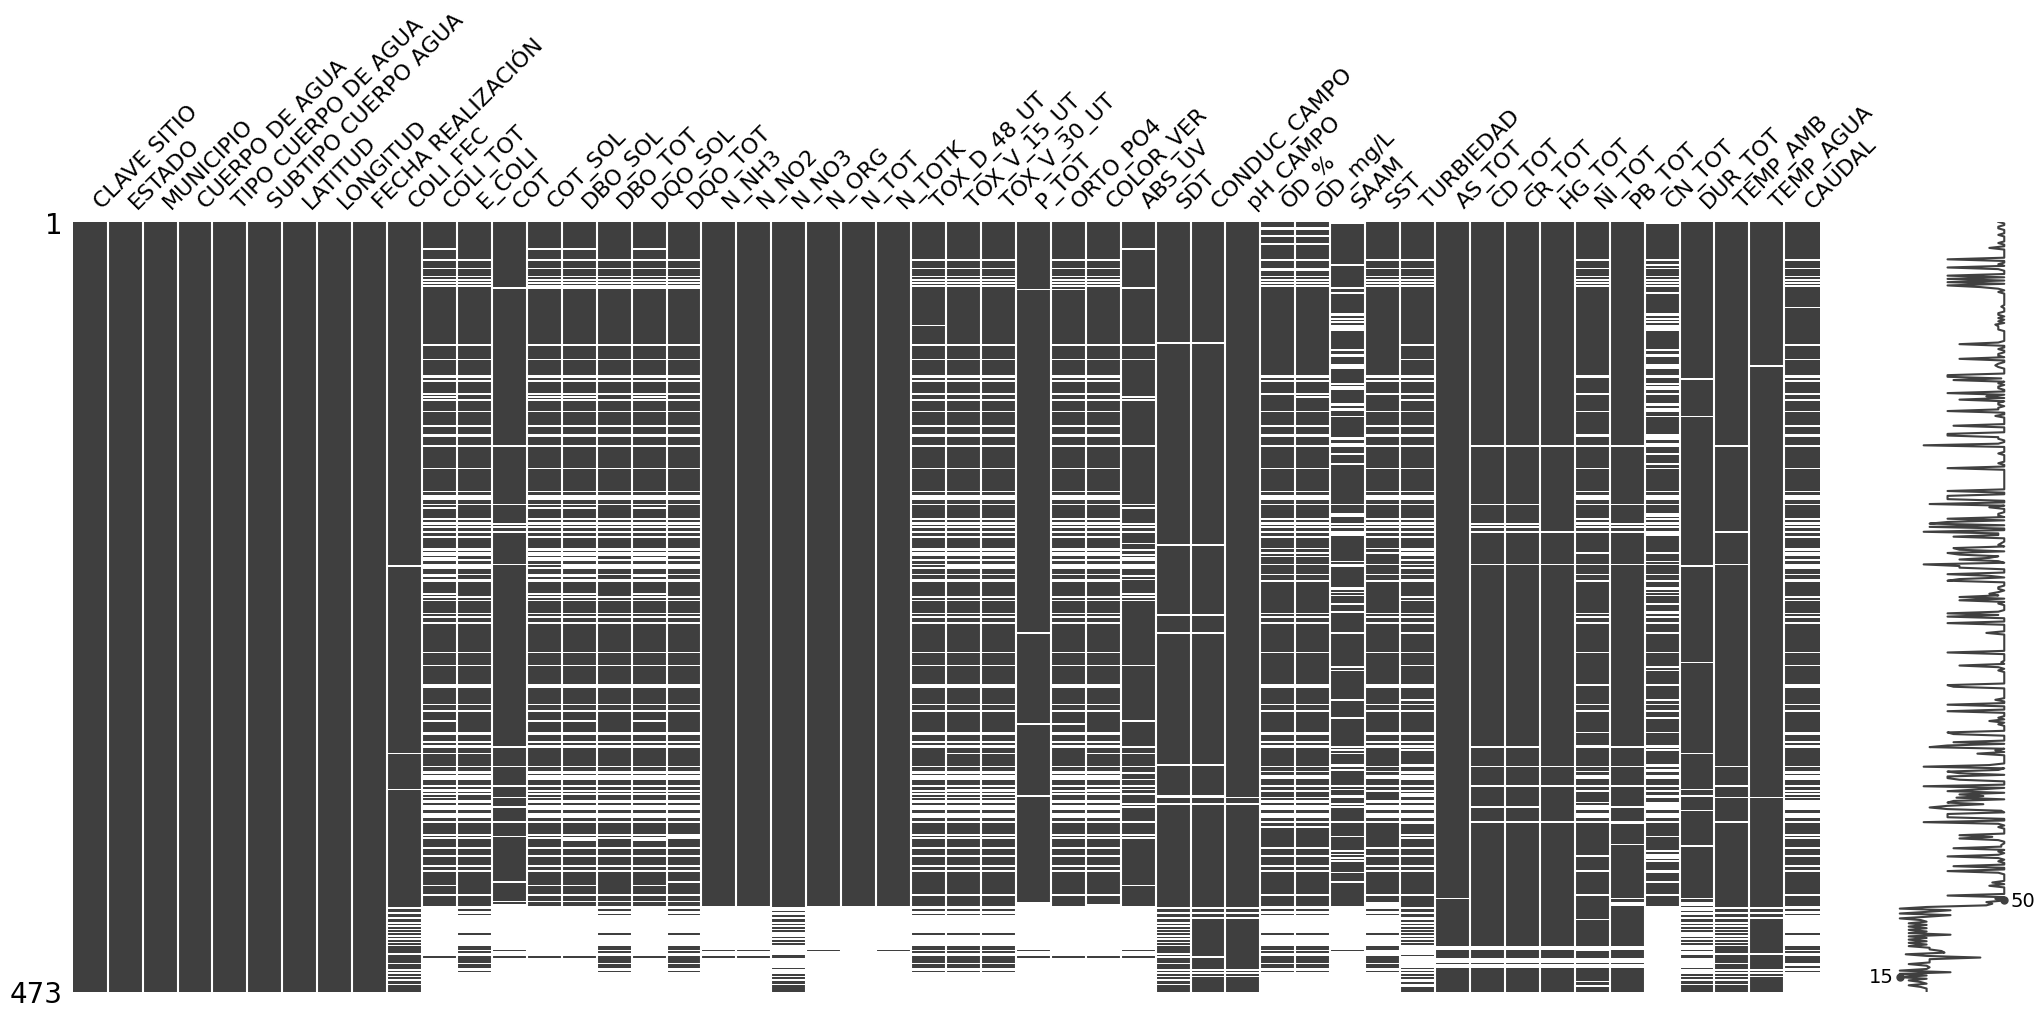

In [13]:
msno.matrix(df_drop_water_sonora.sort_values(by='N_TOT', ascending=True))

Analysing missing values for 'E_COLI'

<Axes: >

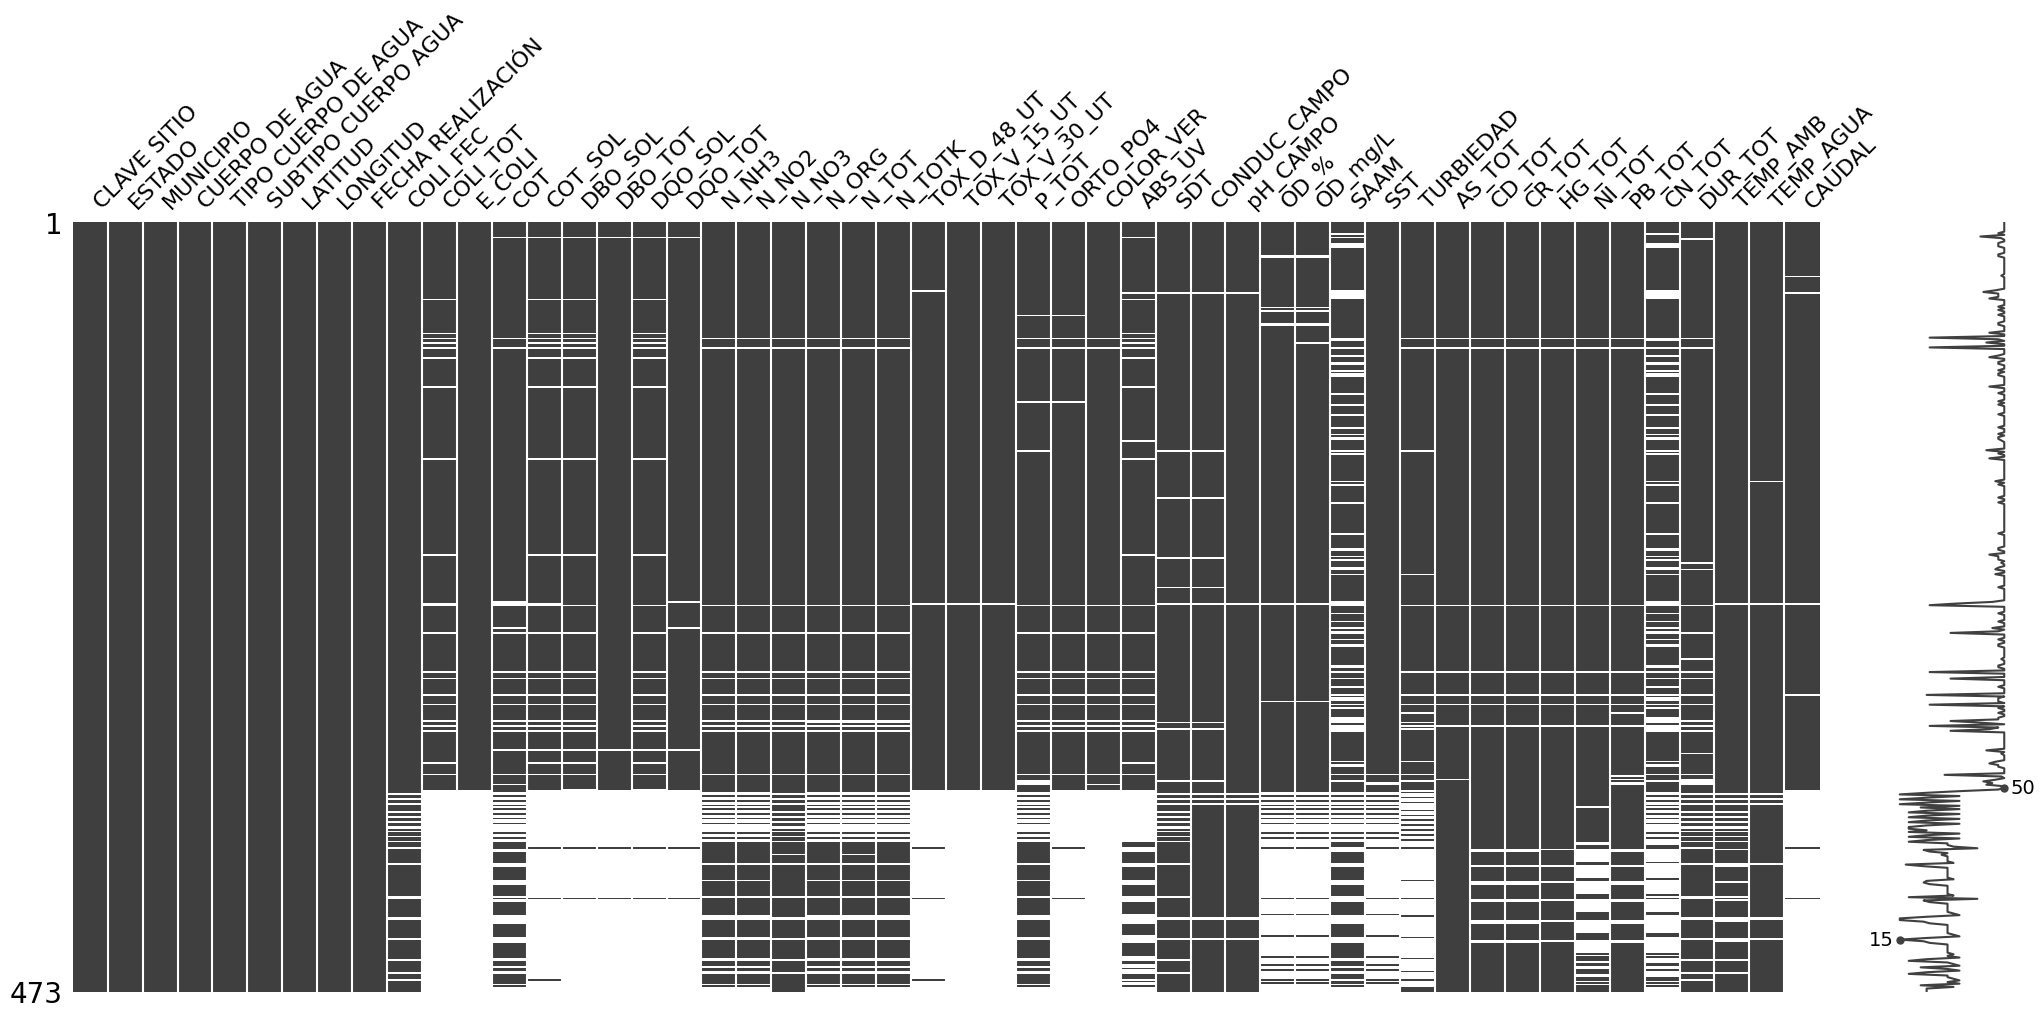

In [14]:
msno.matrix(df_drop_water_sonora.sort_values(by='E_COLI', ascending=True))

<Axes: >

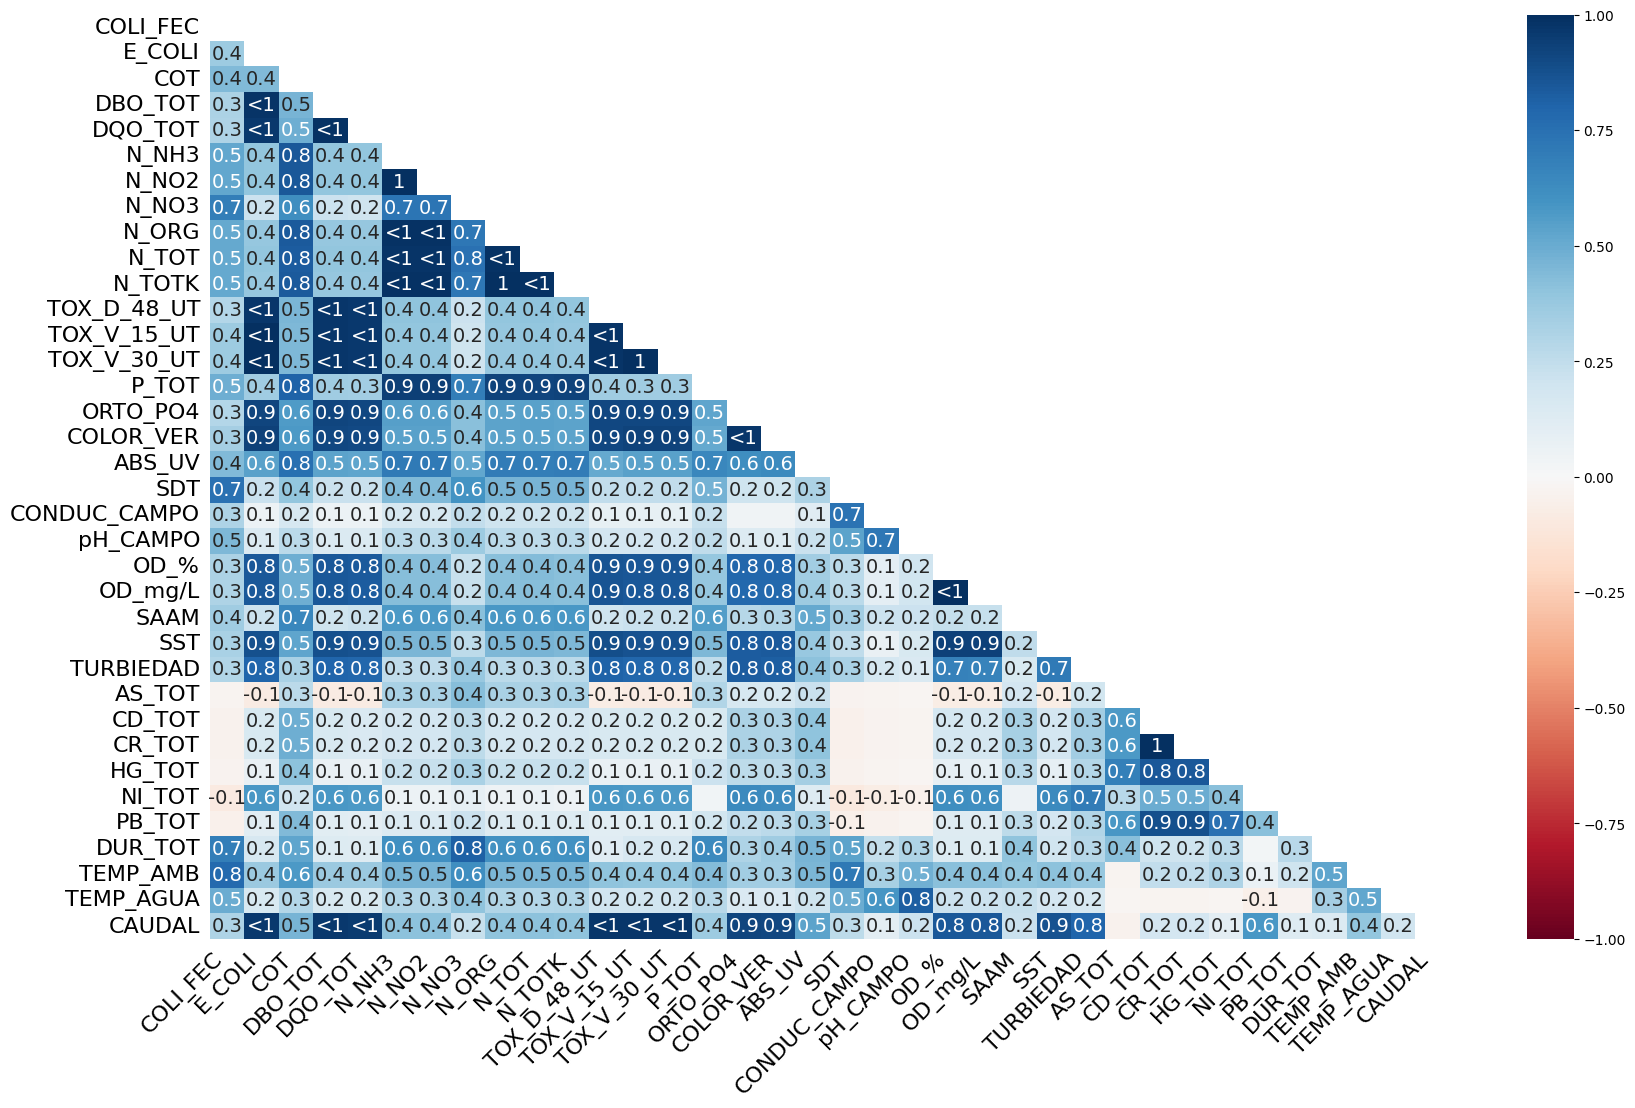

In [119]:
msno.heatmap(df_drop_water_sonora[['COLI_FEC', 'E_COLI', 'COT', 'DBO_TOT', 'DQO_TOT',
       'N_NH3', 'N_NO2', 'N_NO3', 'N_ORG', 'N_TOT', 'N_TOTK', 'TOX_D_48_UT',
       'TOX_V_15_UT', 'TOX_V_30_UT', 'P_TOT', 'ORTO_PO4', 'COLOR_VER',
       'ABS_UV', 'SDT', 'CONDUC_CAMPO', 'pH_CAMPO', 'OD_%', 'OD_mg/L', 'SAAM',
       'SST', 'TURBIEDAD', 'AS_TOT', 'CD_TOT', 'CR_TOT', 'HG_TOT', 'NI_TOT',
       'PB_TOT', 'DUR_TOT', 'TEMP_AMB', 'TEMP_AGUA', 'CAUDAL']], )

In [16]:
df_drop_water_sonora['COLI_FEC'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 473 entries, 0 to 472
Series name: COLI_FEC
Non-Null Count  Dtype  
--------------  -----  
452 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


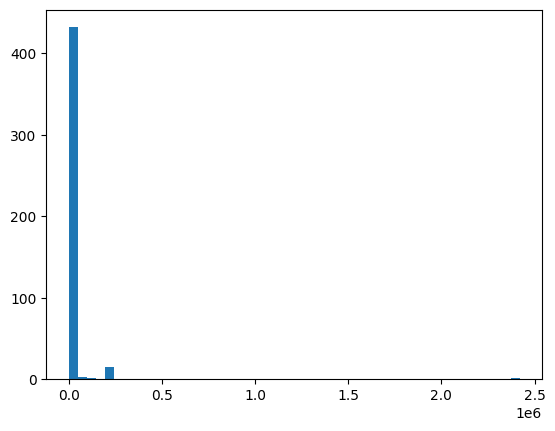

In [17]:
plt.hist(df_drop_water_sonora['COLI_FEC'], bins=50)
plt.show()

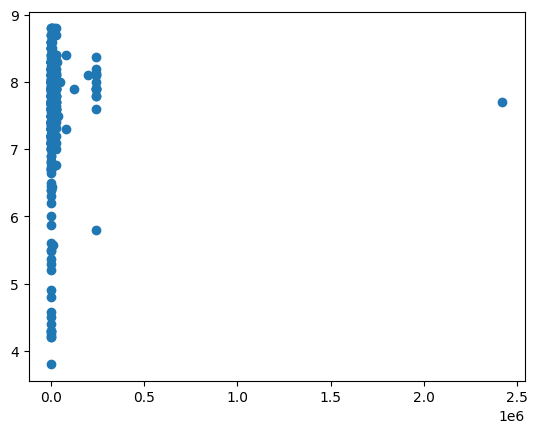

In [18]:
plt.scatter(df_drop_water_sonora['COLI_FEC'], df_drop_water_sonora['pH_CAMPO'])
plt.show()

In [19]:
df_copy_clean_water_sonora = df_drop_water_sonora.copy(deep=True)

In [20]:
df_train_test_COLI_FEC = df_copy_clean_water_sonora[['COLI_FEC', 'pH_CAMPO']]
imputer = IterativeImputer(random_state=0)

# X_train, X_test = train_test_split(df_train_test_COLI_FEC, test_size=0.2, random_state=42)
df_copy_clean_water_sonora[['COLI_FEC', 'pH_CAMPO']] = imputer.fit_transform(df_train_test_COLI_FEC)

In [21]:
df_train_test_E_COLI = df_copy_clean_water_sonora[['E_COLI', 'NI_TOT']]
imputer = IterativeImputer(random_state=0)

# X_train, X_test = train_test_split(df_train_test_E_COLI, test_size=0.2, random_state=42)
df_copy_clean_water_sonora[['E_COLI', 'NI_TOT']] = imputer.fit_transform(df_train_test_E_COLI)

In [22]:
df_train_test_N_TOT = df_copy_clean_water_sonora[['N_TOT', 'SDT']]
imputer = IterativeImputer(random_state=0)

# X_train, X_test = train_test_split(df_train_test_N_TOT, test_size=0.2, random_state=42)
df_copy_clean_water_sonora[['N_TOT', 'SDT']] = imputer.fit_transform(df_train_test_N_TOT)

In [23]:
df_cp_median_clean_water_sonora = df_drop_water_sonora.copy(deep=True)
median_value = df_cp_median_clean_water_sonora['N_TOT'].median()
median_imputation = df_cp_median_clean_water_sonora.fillna(median_value)

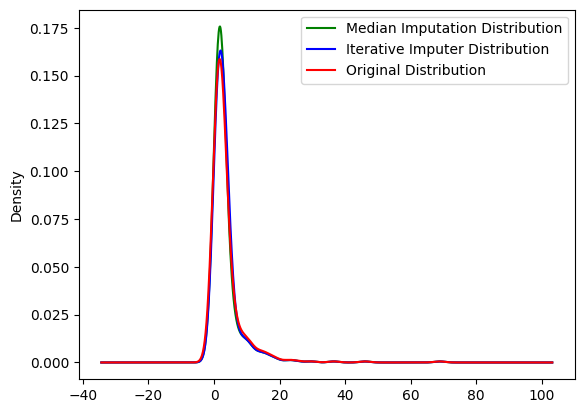

In [34]:
median_imputation['N_TOT'].plot(kind='kde',color='green')
df_copy_clean_water_sonora['N_TOT'].plot(kind='kde',color='blue')
df_drop_water_sonora['N_TOT'].plot(kind='kde',color='red')

plt.legend([
    'Median Imputation Distribution',
    'Iterative Imputer Distribution',
    'Original Distribution'
])
plt.show()

## Others test

In [25]:
# Evaluar los métodos de imputación
mse_mean = mean_squared_error(df_drop_water_sonora['N_TOT'], median_imputation['N_TOT'])
mse_ii = mean_squared_error(df_drop_water_sonora['N_TOT'], df_copy_clean_water_sonora['N_TOT'])

mae_mean = mean_absolute_error(df_drop_water_sonora['N_TOT'], median_imputation['N_TOT'])
mae_ii = mean_absolute_error(df_drop_water_sonora['N_TOT'], df_copy_clean_water_sonora['N_TOT'])

r2_mean = r2_score(df_drop_water_sonora['N_TOT'], median_imputation['N_TOT'])
r2_ii = r2_score(df_drop_water_sonora['N_TOT'], df_copy_clean_water_sonora['N_TOT'])

# Mostrar resultados
print(f"MSE (Imputación Media): {mse_mean:.2f}")
print(f"MSE (Imputación ii): {mse_ii:.2f}")

print(f"MAE (Imputación Media): {mae_mean:.2f}")
print(f"MAE (Imputación ii): {mae_ii:.2f}")

print(f"R² (Imputación Media): {r2_mean:.2f}")
print(f"R² (Imputación ii): {r2_ii:.2f}")

ValueError: Input contains NaN.

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# df_clean_water_sonora[['N_TOT', 'SDT']]

NameError: name 'pd' is not defined

In [51]:
# Importar el módulo experimental para IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

df = df_drop_water_sonora[['N_TOT', 'SDT']]
# Repetir el proceso de imputación y análisis con IterativeImputer habilitado
# 1. Imputación usando diferentes métodos
# - Mediana
median_imputer = SimpleImputer(strategy="median")
df_median = pd.DataFrame(median_imputer.fit_transform(df), columns=df.columns)

# - Moda
mode_imputer = SimpleImputer(strategy="most_frequent")
df_mode = pd.DataFrame(mode_imputer.fit_transform(df), columns=df.columns)

# - SimpleImputer (media)
mean_imputer = SimpleImputer(strategy="mean")
df_mean = pd.DataFrame(mean_imputer.fit_transform(df), columns=df.columns)

# - IterativeImputer
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
df_iterative = pd.DataFrame(iterative_imputer.fit_transform(df), columns=df.columns)

# Calcular las métricas de error para cada método de imputación
def calculate_metrics(original, imputed):
    mae = mean_absolute_error(original, imputed)
    mse = mean_squared_error(original, imputed)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Comparación de resultados usando las filas originales no nulas
mask = ~df["N_TOT"].isna()
original_values = df.loc[mask, "N_TOT"]

# Cálculo de las métricas para cada método
mae_median, mse_median, rmse_median = calculate_metrics(original_values, df_median.loc[mask, "N_TOT"])
mae_mode, mse_mode, rmse_mode = calculate_metrics(original_values, df_mode.loc[mask, "N_TOT"])
mae_mean, mse_mean, rmse_mean = calculate_metrics(original_values, df_mean.loc[mask, "N_TOT"])
mae_iterative, mse_iterative, rmse_iterative = calculate_metrics(original_values, df_iterative.loc[mask, "N_TOT"])

# Resultados en un DataFrame para facilitar la comparación
resultados = pd.DataFrame({
    "Método": ["Mediana", "Moda", "SimpleImputer (Media)", "IterativeImputer"],
    "MAE": [mae_median, mae_mode, mae_mean, mae_iterative],
    "MSE": [mse_median, mse_mode, mse_mean, mse_iterative],
    "RMSE": [rmse_median, rmse_mode, rmse_mean, rmse_iterative]
})

resultados


,Método,MAE,MSE,RMSE
0,Mediana,0.0,0.0,0.0
1,Moda,0.0,0.0,0.0
2,SimpleImputer (Media),0.0,0.0,0.0
3,IterativeImputer,0.0,0.0,0.0


The 'FECHA REALIZACIÓN' column isn't displayed in date format. We need to convert it to the correct format

In [16]:
# First convert the column to numeric
df_water_result['FECHA REALIZACIÓN'] = pd.to_numeric(df_water_result['FECHA REALIZACIÓN'], errors='coerce')

# Then convert to dates from Excel origin
df_water_result['FECHA REALIZACIÓN'] = pd.to_datetime(df_water_result['FECHA REALIZACIÓN'], origin='1899-12-30', unit='D')
# pd.to_datetime(df_water_result['FECHA REALIZACIÓN'].dt.strftime('%d-%m-%Y'), format='%d-%m-%Y', dayfirst=True)

In [17]:
df_water_result.head()

,CLAVE SITIO,CLAVE MONITOREO,NOMBRE DEL SITIO,TIPO CUERPO DE AGUA,FECHA REALIZACIÓN,Año,ALC_FEN,ALC_TOT,CO3,HCO3,...,STV,TALIO_TOT,TER-BUTILBENCENO,Ti_TOT,TRANS-CLORDANO,FORMALDEHIDO,CLORATOS,ACID_CLOROACE,ACID_DICLOROACE,ACID_TRICLOROACE
0,BROTE CARMINA 3,BROTE CARMINA 3-131122,CARMINA 3 BROTE,SUBTERRÁNEO,2022-11-08,2022,NaN,139.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CARMINA 2,CARMINA 2-131122,CARMINA 2,LÓTICO,2022-11-08,2022,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CAZEPA-1,CAZEPA-1-260921,POZO SAN FERNANDO 1,SUBTERRÁNEO,2021-09-23,2021,NaN,148.645,0,148.645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CAZEPA-1,CAZEPA-1-310722,POZO SAN FERNANDO 1,SUBTERRÁNEO,2022-07-27,2022,NaN,141.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAZEPA-1,CAZEPA-1-181023,POZO SAN FERNANDO 1,SUBTERRÁNEO,2023-10-18,2023,0,210.24,0,210.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
print(df_water_result.info())  # Structure summary
print('\n----------------------------------------------------\n')
print(df_water_result.describe())  # Statistical summary of numerical columns
print('\n----------------------------------------------------\n')
print(df_water_result.isnull().sum())  # Check for null values
print('\n----------------------------------------------------\n')
print(df_water_result.duplicated().sum())  # Check for duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127424 entries, 0 to 127423
Columns: 452 entries, CLAVE SITIO to ACID_TRICLOROACE
dtypes: datetime64[ns](1), float64(73), int64(1), object(377)
memory usage: 439.4+ MB
None

----------------------------------------------------

                   FECHA REALIZACIÓN            Año  CONDUC_CAMPO_SUP  \
count                         127420  127424.000000      41627.000000   
mean   2016-05-25 00:09:29.198022400    2015.911273      30362.139897   
min              2012-03-12 00:00:00    2012.000000          8.680000   
25%              2014-05-29 00:00:00    2014.000000        814.500000   
50%              2016-04-14 00:00:00    2016.000000      37350.000000   
75%              2018-02-05 00:00:00    2018.000000      53748.500000   
max              2023-12-12 00:00:00    2023.000000     556020.000000   
std                              NaN       2.422348      26813.992809   

           pH_CAMPO  pH_CAMPO_SUP  pH_CAMPO_MED  pH_CAMPO_FON  H

### Data Frame Merged

Merging df_water_site and df_water_result DataFrames using 'CLAVE SITIO' as the key. The 'inner' join returns only rows with matching values in both DataFrames.

In [19]:
df_water_merged = pd.merge(df_water_site, df_water_result, on='CLAVE SITIO', how='inner')
df_water_merged.head(10)

,CLAVE SITIO,NOMBRE DEL SITIO_x,CUENCA,CLAVE ACUÍFERO,ACUÍFERO,ORGANISMO CUENCA,DIRECCIÓN LOCAL,ESTADO,MUNICIPIO,CUERPO DE AGUA,...,STV,TALIO_TOT,TER-BUTILBENCENO,Ti_TOT,TRANS-CLORDANO,FORMALDEHIDO,CLORATOS,ACID_CLOROACE,ACID_DICLOROACE,ACID_TRICLOROACE
0,OCPYU4929,COSGAYA,NaN,3105.0,PENÍNSULA DE YUCATÁN,PENÍNSULA DE YUCATÁN,NaN,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OCPYU4929,COSGAYA,NaN,3105.0,PENÍNSULA DE YUCATÁN,PENÍNSULA DE YUCATÁN,NaN,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OCPYU4929,COSGAYA,NaN,3105.0,PENÍNSULA DE YUCATÁN,PENÍNSULA DE YUCATÁN,NaN,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OCPYU4929,COSGAYA,NaN,3105.0,PENÍNSULA DE YUCATÁN,PENÍNSULA DE YUCATÁN,NaN,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OCPYU4929,COSGAYA,NaN,3105.0,PENÍNSULA DE YUCATÁN,PENÍNSULA DE YUCATÁN,NaN,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,OCPYU4929,COSGAYA,NaN,3105.0,PENÍNSULA DE YUCATÁN,PENÍNSULA DE YUCATÁN,NaN,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,OCPYU4929,COSGAYA,NaN,3105.0,PENÍNSULA DE YUCATÁN,PENÍNSULA DE YUCATÁN,NaN,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,OCPYU4929,COSGAYA,NaN,3105.0,PENÍNSULA DE YUCATÁN,PENÍNSULA DE YUCATÁN,NaN,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,OCPYU4929,COSGAYA,NaN,3105.0,PENÍNSULA DE YUCATÁN,PENÍNSULA DE YUCATÁN,NaN,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,OCPYU4929,COSGAYA,NaN,3105.0,PENÍNSULA DE YUCATÁN,PENÍNSULA DE YUCATÁN,NaN,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
print(df_water_merged.info())  # Structure summary
print('\n----------------------------------------------------\n')
print(df_water_merged.describe())  # Statistical summary of numerical columns
print('\n----------------------------------------------------\n')
print(df_water_merged.isnull().sum())  # Check for null values
print('\n----------------------------------------------------\n')
print(df_water_merged.duplicated().sum())  # Check for duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127424 entries, 0 to 127423
Columns: 465 entries, CLAVE SITIO to ACID_TRICLOROACE
dtypes: datetime64[ns](1), float64(76), int64(1), object(387)
memory usage: 452.1+ MB
None

----------------------------------------------------

       CLAVE ACUÍFERO        LATITUD       LONGITUD  \
count    13450.000000  127424.000000  127424.000000   
mean      1713.954796      21.391787    -100.672892   
min        101.000000      14.534910    -117.124028   
25%       1002.000000      18.507650    -104.329408   
50%       1506.000000      20.377210    -100.002660   
75%       2626.000000      23.998210     -97.074460   
max       3231.000000      32.706497     100.859540   
std        985.009996       4.043795       6.134039   

                   FECHA REALIZACIÓN            Año  CONDUC_CAMPO_SUP  \
count                         127420  127424.000000      41627.000000   
mean   2016-05-25 00:09:29.198022400    2015.911273      30362.139897   
min    

Select the columns required for the study

In [21]:
df_water_merged_filtered = df_water_merged[['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'] + POLLUTANTS]
df_water_merged_filtered.head()

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD,FECHA REALIZACIÓN,ALC_FEN,...,STV,TALIO_TOT,TER-BUTILBENCENO,Ti_TOT,TRANS-CLORDANO,FORMALDEHIDO,CLORATOS,ACID_CLOROACE,ACID_DICLOROACE,ACID_TRICLOROACE
0,OCPYU4929,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,SUBTERRÁNEO (ESTUDIO ESPECIAL),POZO,21.09699,-89.7046,2012-11-27,<25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OCPYU4929,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,SUBTERRÁNEO (ESTUDIO ESPECIAL),POZO,21.09699,-89.7046,2013-09-18,<25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OCPYU4929,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,SUBTERRÁNEO (ESTUDIO ESPECIAL),POZO,21.09699,-89.7046,2014-02-12,<25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OCPYU4929,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,SUBTERRÁNEO (ESTUDIO ESPECIAL),POZO,21.09699,-89.7046,2015-05-18,<25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OCPYU4929,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,SUBTERRÁNEO (ESTUDIO ESPECIAL),POZO,21.09699,-89.7046,2016-04-26,<25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Filter the DataFrame to obtain only the records of the water bodies that are not "COASTAL" of the affected municipalities of the state of Sonora.

In [22]:
df_water_merged_sonora = df_water_merged_filtered[
    (df_water_merged['ESTADO'] == 'SONORA') &
    (df_water_merged['MUNICIPIO'].isin(MUNICIPALITY))   
]
df_water_merged_sonora = df_water_merged_sonora[~df_water_merged_sonora['TIPO CUERPO DE AGUA'].str.contains('COSTERO', na=False)]
df_water_merged_sonora.head()

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD,FECHA REALIZACIÓN,ALC_FEN,...,STV,TALIO_TOT,TER-BUTILBENCENO,Ti_TOT,TRANS-CLORDANO,FORMALDEHIDO,CLORATOS,ACID_CLOROACE,ACID_DICLOROACE,ACID_TRICLOROACE
94719,OCNOR3987,SONORA,CANANEA,RIO SONORA,LÓTICO,RÍO,30.95804,-110.18906,2012-11-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94720,OCNOR3987,SONORA,CANANEA,RIO SONORA,LÓTICO,RÍO,30.95804,-110.18906,2013-01-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94721,OCNOR3987,SONORA,CANANEA,RIO SONORA,LÓTICO,RÍO,30.95804,-110.18906,2013-03-08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94722,OCNOR3987,SONORA,CANANEA,RIO SONORA,LÓTICO,RÍO,30.95804,-110.18906,2013-04-25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94723,OCNOR3987,SONORA,CANANEA,RIO SONORA,LÓTICO,RÍO,30.95804,-110.18906,2013-06-04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
print(df_water_merged_sonora.info())  # Structure summary
print('\n----------------------------------------------------\n')
print(df_water_merged_sonora.describe())  # Statistical summary of numerical columns
print('\n----------------------------------------------------\n')
print(df_water_merged_sonora.isnull().sum())  # Check for null values
print('\n----------------------------------------------------\n')
print(df_water_merged_sonora.duplicated().sum())  # Check for duplicates

<class 'pandas.core.frame.DataFrame'>
Index: 473 entries, 94719 to 126167
Columns: 414 entries, CLAVE SITIO to ACID_TRICLOROACE
dtypes: datetime64[ns](1), float64(35), object(378)
memory usage: 1.5+ MB
None

----------------------------------------------------

          LATITUD    LONGITUD              FECHA REALIZACIÓN  \
count  473.000000  473.000000                            473   
mean    30.112463 -110.245170  2017-02-16 08:46:40.845666048   
min     29.321070 -110.541560            2012-11-10 00:00:00   
25%     29.723690 -110.288770            2014-08-24 00:00:00   
50%     29.854986 -110.201140            2016-08-25 00:00:00   
75%     30.373350 -110.160940            2018-10-19 00:00:00   
max     31.085050 -110.033860            2023-12-05 00:00:00   
std      0.568081    0.124845                            NaN   

       CONDUC_CAMPO_SUP    pH_CAMPO  pH_CAMPO_SUP  pH_CAMPO_MED  pH_CAMPO_FON  \
count               0.0  465.000000           0.0           0.0           0.0   

Clean the columns of contaminants by removing the > and < symbols and converting them to numeric

In [24]:
# Clean the columns of contaminants by removing the > and < symbols and converting them to numeric
for column in POLLUTANTS:
    if column in df_water_merged_sonora.columns:
        df_water_merged_sonora[column] = df_water_merged_sonora[column].astype(str)
        df_water_merged_sonora[column] = (
            df_water_merged_sonora[column]
            .str.replace('<', '', regex=False)
            .str.replace('>', '', regex=False)
        )
        df_water_merged_sonora[column] = pd.to_numeric(df_water_merged_sonora[column], errors='coerce')

print(df_water_merged_sonora.info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 473 entries, 94719 to 126167
Columns: 414 entries, CLAVE SITIO to ACID_TRICLOROACE
dtypes: datetime64[ns](1), float64(407), object(6)
memory usage: 1.5+ MB
None


Sort by 'CLAVE SITIO' and 'FECHA REALIZACIÓN' in ascending order

In [25]:
df_water_merged_sonora.sort_values(by=['CLAVE SITIO', 'FECHA REALIZACIÓN'], ascending=True, inplace=True, ignore_index=True)
df_water_merged_sonora.head()

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD,FECHA REALIZACIÓN,ALC_FEN,...,STV,TALIO_TOT,TER-BUTILBENCENO,Ti_TOT,TRANS-CLORDANO,FORMALDEHIDO,CLORATOS,ACID_CLOROACE,ACID_DICLOROACE,ACID_TRICLOROACE
0,MET-001,SONORA,ARIZPE,ACUÍFERO BACANUCHI,SUBTERRÁNEO,POZO,30.603729,-110.226908,2021-09-07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MET-001,SONORA,ARIZPE,ACUÍFERO BACANUCHI,SUBTERRÁNEO,POZO,30.603729,-110.226908,2022-07-25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MET-001,SONORA,ARIZPE,ACUÍFERO BACANUCHI,SUBTERRÁNEO,POZO,30.603729,-110.226908,2023-12-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MET-003,SONORA,ARIZPE,RIO BACANUCHI,LÓTICO,RÍO,30.575670,-110.220880,2022-07-25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MET-010,SONORA,ARIZPE,ACUÍFERO RÍO SONORA,SUBTERRÁNEO,POZO,30.347310,-110.157320,2021-10-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
INTERIM_WATER_DATA_DIR = INTERIM_DATA_DIR / 'water_interim.parquet'
table = pa.Table.from_pandas(df_water_merged)

with pq.ParquetWriter(INTERIM_WATER_DATA_DIR, table.schema) as writer:
    writer.write_table(table)

ArrowTypeError: ("Expected bytes, got a 'int' object", 'Conversion failed for column ALC_FEN with type object')

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

### Another tests

In [19]:
df_water_site_keys = df_water_site.keys()
df_water_site_keys

Index(['CLAVE SITIO', 'NOMBRE DEL SITIO', 'CUENCA', 'CLAVE ACUÍFERO',
       'ACUÍFERO', 'ORGANISMO CUENCA', 'DIRECCIÓN LOCAL', 'ESTADO',
       'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO DE CUERPO DE AGUA',
       'SUBTIPO CUERPO AGUA', 'LATITUD', 'LONGITUD'],
      dtype='object')

In [20]:
df_water_result_keys = df_water_result.keys()
print(df_water_result_keys)

Index(['CLAVE SITIO', 'CLAVE MONITOREO', 'NOMBRE DEL SITIO',
       'TIPO CUERPO DE AGUA', 'FECHA REALIZACIÓN', 'Año', 'ALC_FEN', 'ALC_TOT',
       'CO3', 'HCO3',
       ...
       'STV', 'TALIO_TOT', 'TER-BUTILBENCENO', 'Ti_TOT', 'TRANS-CLORDANO',
       'FORMALDEHIDO', 'CLORATOS', 'ACID_CLOROACE', 'ACID_DICLOROACE',
       'ACID_TRICLOROACE'],
      dtype='object', length=452)


In [21]:
check = df_water_result_keys.isin(['OD_mg/L', 'DBO_TOT', 'DQO_TOT', 'COLI_FEC', 'E_COLI', 'N_TOT', 'P_TOT', 'TOX_D_48_UT', 'TOX_FIS_SUP_15_UT' ])
# print(check)
print(Counter(check))

Counter({np.False_: 443, np.True_: 9})


In [22]:
# Filter 'df_water_site' to only include necesary columns
df_water_site_filtered = df_water_site[['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 'LATITUD', 'LONGITUD']]
df_water_site_filtered.head()

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD
0,OCPYU4929,YUCATÁN,MÉRIDA,ACUÍFERO PENÍNSULA DE YUCATÁN,POZO,21.096990,-89.704600
1,OCPYU4946,YUCATÁN,SOTUTA,ACUÍFERO PENÍNSULA DE YUCATÁN,POZO,20.597040,-89.007570
2,OCPYU4953W1,YUCATÁN,KOPOMÁ,ACUÍFERO PENÍNSULA DE YUCATÁN,CENOTE,20.689430,-89.876050
3,OCPYU6396,YUCATÁN,CACALCHEN,ACUÍFERO PENINSULA DE YUCATAN,POZO,20.982222,-89.227778
4,OCPYU6397,YUCATÁN,CANSAHCAB,ACUÍFERO PENINSULA DE YUCATAN,POZO,21.156850,-89.089960


In [23]:
# The 'municipality' list includes only the municipalities affected by the spill.
municipality = ['ARIZPE', 'BANÁMICHI', 'HUÉPAC', 'ACONCHI', 'SAN FELIPE', 'BAVIÁCORA Y URES']

In [24]:
df_water_site_filtered_sonora = df_water_site_filtered[
    df_water_site_filtered['ESTADO'] == 'SONORA'
]
df_water_site_filtered_sonora['MUNICIPIO'].unique()

array(['AGUA PRIETA', 'CANANEA', 'ACONCHI', 'HUÁSABAS', 'SANTA CRUZ',
       'NOGALES', 'TUBUTAMA', 'ATIL', 'OQUITOA', 'ALTAR', 'TRINCHERAS',
       'SANTA ANA', 'CUMPAS', 'SAHUARIPA', 'CARBÓ',
       'SAN MIGUEL DE HORCASITAS', 'URES', 'BAVIÁCORA', 'BANÁMICHI',
       'ARIZPE', 'BACOACHI', 'IMURIS', 'BENJAMÍN HILL', 'OPODEPE',
       'HERMOSILLO', 'LA COLORADA', 'SOYOPA', 'ONAVAS',
       'SAN PEDRO DE LA CUEVA', 'BACANORA', 'TEPACHE', 'DIVISADEROS',
       'NACOZARI DE GARCÍA', 'ALAMOS', 'HUATABAMPO', 'ETCHOJOA', 'NACO',
       'NAVOJOA', 'CAJEME', 'BÁCUM', 'SAN IGNACIO RÍO MUERTO', 'GUAYMAS',
       'QUIRIEGO', 'ROSARIO', 'EMPALME', 'PUERTO PEÑASCO', 'CABORCA',
       'GENERAL PLUTARCO ELÍAS CALLES', 'MAGDALENA', 'MOCTEZUMA',
       'RAYON ', 'SAN JAVIER', 'VILLA HIDALGO', 'BACADEHUACHI',
       'BAVIACORA', 'CUCURPE', 'HUEPAC', 'MAZATAN', 'NACOZARI DE GARCIA',
       'SAN FELIPE', 'SAN PEDRO DE CUEVA', 'SUAQUI GRANDE',
       'VILLA PESQUEIRA', 'ARIVECHI', 'BACERAC', 'BAVISPE', 'FR

In [25]:
df_water_site_filtered_sonora = df_water_site_filtered[
    (df_water_site_filtered['ESTADO'] == 'SONORA') &
    (df_water_site_filtered['MUNICIPIO'].isin(municipality))    
]
df_water_site_filtered_sonora.head()

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD
4697,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754
4728,OCNOR4021,SONORA,ACONCHI,ACUÍFERO RIO SONORA,POZO,29.77367,-110.20114
4729,OCNOR4022,SONORA,ACONCHI,RIO SONORA,RÍO,29.82440,-110.23701
4730,OCNOR4023,SONORA,BANÁMICHI,RIO SONORA,RÍO,30.01704,-110.21963
4731,OCNOR4024,SONORA,ARIZPE,RIO SONORA,RÍO,30.33503,-110.16534


In [26]:
df_water_site_filtered_sonora.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 4697 to 6491
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          25 non-null     object 
 1   ESTADO               25 non-null     object 
 2   MUNICIPIO            25 non-null     object 
 3   CUERPO DE AGUA       25 non-null     object 
 4   SUBTIPO CUERPO AGUA  25 non-null     object 
 5   LATITUD              25 non-null     float64
 6   LONGITUD             25 non-null     float64
dtypes: float64(2), object(5)
memory usage: 1.6+ KB


In [27]:
# The 'pollutants' list includes the pollutants that will be used in this study
pollutants = ['OD_mg/L', 'DBO_TOT', 'DQO_TOT', 'COLI_FEC', 'E_COLI', 'N_TOT', 'P_TOT', 'TOX_D_48_UT', 'TOX_FIS_SUP_15_UT' ]

In [28]:
body_of_water = df_water_result['TIPO CUERPO DE AGUA'].unique()
body_of_water

# The 'body_of_water' list includes the type of water body you want to study.
body_of_water = []

In [29]:
# Filter 'df_water_result' to only include necesary columns
df_water_result_filtered = df_water_result[['CLAVE SITIO', 'TIPO CUERPO DE AGUA', 'Año'] + pollutants]

# # Filter 'df water_result' so that it does not include any water body type related to 'COSTERO', since this type of water body is not useful for the study
df_water_result_filtered = df_water_result_filtered[~df_water_result_filtered['TIPO CUERPO DE AGUA'].str.contains('COSTERO', na=False)]
print(df_water_result_filtered['TIPO CUERPO DE AGUA'].unique())
df_water_result_filtered.head()

['SUBTERRÁNEO' 'LÓTICO' 'LÉNTICO' 'LÉNTICO (HUMEDAL)' 'LÓTICO (HUMEDAL)'
 'LÓTICO (ESTUDIO ESPECIAL)' 'SUBTERRÁNEO (ESTUDIO ESPECIAL)'
 'LÉNTICO (ESTUDIO ESPECIAL)' 'LENTICO (HUMEDAL)' 'SUBTERRÁNEO (HUMEDAL)'
 'LÓTICO Y SEDIMENTOS']


,CLAVE SITIO,TIPO CUERPO DE AGUA,Año,OD_mg/L,DBO_TOT,DQO_TOT,COLI_FEC,E_COLI,N_TOT,P_TOT,TOX_D_48_UT,TOX_FIS_SUP_15_UT
0,BROTE CARMINA 3,SUBTERRÁNEO,2022,NaN,NaN,NaN,97,NaN,NaN,NaN,NaN,NaN
1,CARMINA 2,LÓTICO,2022,8.13,<2,<10,1076,41,NaN,NaN,<1,NaN
2,CAZEPA-1,SUBTERRÁNEO,2021,5.96,NaN,NaN,<10,NaN,0.612951,0.0381,NaN,NaN
3,CAZEPA-1,SUBTERRÁNEO,2022,NaN,NaN,NaN,<10,NaN,NaN,NaN,NaN,NaN
4,CAZEPA-1,SUBTERRÁNEO,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_water_merged = pd.merge(df_water_site_filtered_sonora, df_water_result_filtered, on='CLAVE SITIO', how='inner')
df_water_merged.head(10)

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD,TIPO CUERPO DE AGUA,Año,OD_mg/L,DBO_TOT,DQO_TOT,COLI_FEC,E_COLI,N_TOT,P_TOT,TOX_D_48_UT,TOX_FIS_SUP_15_UT
0,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754,LÓTICO,2012,<1,104.51,193.8,<3,<3,5.7786,2.0608,<1,NaN
1,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754,LÓTICO,2013,NaN,256,1020.572,>24196,305,5.6104,5.0175,NaN,NaN
2,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754,LÓTICO,2013,6.21,2.08,26.4,110,52,0.6545,0.055,1.28,NaN
3,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754,LÓTICO,2013,7.13,4.01,13.8,1145,160,0.3137,0.0204,<1,NaN
4,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754,LÓTICO,2013,7.3,3.09,21.112,2247,<1,0.326,0.034,<1,NaN
5,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754,LÓTICO,2014,7.2,2.8,42.61,1674,1470,0.177,0.042,<1,NaN
6,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754,LÓTICO,2014,5.9,4.7,74.34,7270,479,0.564,0.04,<1,NaN
7,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754,LÓTICO,2014,6.4,21.5,54.64,>24196,110,0.058,0.001,<1,NaN
8,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754,LÓTICO,2014,7.7,<2,<10,2851,10,0.299,0.017,<1,NaN
9,OCNOR3990,SONORA,ACONCHI,RIO SONORA,RÍO,29.84478,-110.27754,LÓTICO,2015,8.76,<2,<10,187,<1,0.156198,0.013936,<1,NaN


In [31]:
print(df_water_merged.info())  # Structure summary
print('\n----------------------------------------------------\n')
print('\n----------------------------------------------------\n')
print(df_water_merged.isnull().sum())  # Check for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          219 non-null    object 
 1   ESTADO               219 non-null    object 
 2   MUNICIPIO            219 non-null    object 
 3   CUERPO DE AGUA       219 non-null    object 
 4   SUBTIPO CUERPO AGUA  219 non-null    object 
 5   LATITUD              219 non-null    float64
 6   LONGITUD             219 non-null    float64
 7   TIPO CUERPO DE AGUA  219 non-null    object 
 8   Año                  219 non-null    int64  
 9   OD_mg/L              146 non-null    object 
 10  DBO_TOT              144 non-null    object 
 11  DQO_TOT              144 non-null    object 
 12  COLI_FEC             207 non-null    object 
 13  E_COLI               143 non-null    object 
 14  N_TOT                190 non-null    object 
 15  P_TOT                187 non-null    obj

In [32]:
# Clean the columns of contaminants by removing the > and < symbols and converting them to numeric
for column in pollutants:
    if column in df_water_merged.columns:
        df_water_merged[column] = df_water_merged[column].astype(str)
        df_water_merged[column] = (
            df_water_merged[column]
            .str.replace('<', '', regex=False)
            .str.replace('>', '', regex=False)
        )
        df_water_merged[column] = pd.to_numeric(df_water_merged[column], errors='coerce')

print(df_water_merged.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          219 non-null    object 
 1   ESTADO               219 non-null    object 
 2   MUNICIPIO            219 non-null    object 
 3   CUERPO DE AGUA       219 non-null    object 
 4   SUBTIPO CUERPO AGUA  219 non-null    object 
 5   LATITUD              219 non-null    float64
 6   LONGITUD             219 non-null    float64
 7   TIPO CUERPO DE AGUA  219 non-null    object 
 8   Año                  219 non-null    int64  
 9   OD_mg/L              146 non-null    float64
 10  DBO_TOT              144 non-null    float64
 11  DQO_TOT              144 non-null    float64
 12  COLI_FEC             207 non-null    float64
 13  E_COLI               143 non-null    float64
 14  N_TOT                190 non-null    float64
 15  P_TOT                187 non-null    flo

In [33]:
INTERIM_WATER_DATA_DIR = INTERIM_DATA_DIR / 'water_interim.parquet'
table = pa.Table.from_pandas(df_water_merged)

with pq.ParquetWriter(INTERIM_WATER_DATA_DIR, table.schema) as writer:
    writer.write_table(table)

In [34]:
df = pd.read_parquet(INTERIM_WATER_DATA_DIR)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          219 non-null    object 
 1   ESTADO               219 non-null    object 
 2   MUNICIPIO            219 non-null    object 
 3   CUERPO DE AGUA       219 non-null    object 
 4   SUBTIPO CUERPO AGUA  219 non-null    object 
 5   LATITUD              219 non-null    float64
 6   LONGITUD             219 non-null    float64
 7   TIPO CUERPO DE AGUA  219 non-null    object 
 8   Año                  219 non-null    int64  
 9   OD_mg/L              146 non-null    float64
 10  DBO_TOT              144 non-null    float64
 11  DQO_TOT              144 non-null    float64
 12  COLI_FEC             207 non-null    float64
 13  E_COLI               143 non-null    float64
 14  N_TOT                190 non-null    float64
 15  P_TOT                187 non-null    flo

In [35]:
df_water_result_filtered['FECHA REALIZACIÓN'] = pd.to_datetime(df_water_result_filtered['FECHA REALIZACIÓN'], format='%m/%d/%Y', errors='coerce')
df_water_result_filtered.head()

KeyError: 'FECHA REALIZACIÓN'